INSTALL DEPENDENCIES (to be run only once in terminal)

In [1]:
"""!pip install torch
!pip install pandas numpy scikit-learn
!pip install matplotlib seaborn
!pip install tqdm """


'!pip install torch\n!pip install pandas numpy scikit-learn\n!pip install matplotlib seaborn\n!pip install tqdm '

IMPORT LIBRARIES

In [2]:
# Basic utilities
import json
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm import tqdm

# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix


LOAD VOCABULARY

In [3]:
# Load vocabulary created in Notebook 01
with open("vocab.json", "r") as f:
    vocab = json.load(f)

vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)


Vocabulary size: 81589


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


MODEL DEFINITION (RNN / LSTM / GRU)

In [5]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, model_type):
        super().__init__()

        self.embedding = nn.Embedding(
            vocab_size, embed_dim, padding_idx=0
        )

        if model_type == "rnn":
            self.recurrent = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        elif model_type == "lstm":
            self.recurrent = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        elif model_type == "gru":
            self.recurrent = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        else:
            raise ValueError("model_type must be one of: rnn, lstm, gru")

        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x, lengths):
        x = self.embedding(x)

        packed = nn.utils.rnn.pack_padded_sequence(
            x,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        _, hidden = self.recurrent(packed)

        # LSTM returns (hidden, cell)
        if isinstance(hidden, tuple):
            hidden = hidden[0]

        return self.fc(hidden[-1])



MODEL INITIALIZATION

In [6]:
# Define model parameters
EMBED_DIM = 128
HIDDEN_DIM = 128

models = {
    "RNN": SentimentRNN(vocab_size, EMBED_DIM, HIDDEN_DIM, "rnn").to(device),
    "LSTM": SentimentRNN(vocab_size, EMBED_DIM, HIDDEN_DIM, "lstm").to(device),
    "GRU": SentimentRNN(vocab_size, EMBED_DIM, HIDDEN_DIM, "gru").to(device)
}


LOSS FUNCTION & OPTIMIZER

In [7]:
criterion = nn.CrossEntropyLoss()
#Each model will get its own optimizer to avoid parameter leakage.

TRAINING FUNCTION

In [8]:
def train_model(model, train_loader, val_loader, epochs=3, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        correct, total, running_loss = 0, 0, 0

        for x, lengths, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            lengths = lengths.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            outputs = model(x, lengths)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)

        # Validation
        model.eval()
        correct, total, running_loss = 0, 0, 0

        with torch.no_grad():
            for x, lengths, y in val_loader:
                x = x.to(device)
                lengths = lengths.to(device)
                y = y.to(device)

                outputs = model(x, lengths)
                loss = criterion(outputs, y)

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_losses.append(running_loss / len(val_loader))
        val_accs.append(correct / total)

        print(
            f"Epoch {epoch+1} | "
            f"Train Acc: {train_accs[-1]:.4f} | "
            f"Val Acc: {val_accs[-1]:.4f}"
        )

    return train_losses, val_losses, train_accs, val_accs


LOAD DATA & REBUILD DATALOADERS

In [9]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [10]:
# Load processed dataset
df = pd.read_csv("IMDB Dataset.csv")

# Reload vocabulary
with open("vocab.json", "r") as f:
    vocab = json.load(f)

MAX_LEN = 500

In [11]:
import re
# Rebuild preprocessing functions
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text):
    return text.split()

def encode_tokens(tokens, vocab):
    return [vocab.get(word, vocab["<UNK>"]) for word in tokens]

def pad_sequence(seq, max_len):
    if len(seq) < max_len:
        return seq + [vocab["<PAD>"]] * (max_len - len(seq))
    return seq[:max_len]


In [12]:
# Apply preprocessing
df["clean_review"] = df["review"].apply(clean_text)
df["tokens"] = df["clean_review"].apply(tokenize)
df["encoded"] = df["tokens"].apply(lambda x: encode_tokens(x, vocab))
df["padded"] = df["encoded"].apply(lambda x: pad_sequence(x, MAX_LEN))
labels = (df["sentiment"] == "positive").astype(int).values


In [13]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    df["padded"].tolist(),
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)


In [14]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        length = sum(1 for t in text if t != 0)  # count non-PAD tokens

        return (
            torch.tensor(text, dtype=torch.long),
            length,
            torch.tensor(self.labels[idx], dtype=torch.long)
        )

    



In [15]:
    # DataLoaders
train_dataset = IMDBDataset(X_train, y_train)
val_dataset   = IMDBDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))


Train batches: 1250
Validation batches: 313


TRAINING: SIMPLE RNN

In [16]:
print("Training Simple RNN")

rnn_model = models["RNN"]

rnn_train_losses, rnn_val_losses, rnn_train_accs, rnn_val_accs = train_model(
    rnn_model,
    train_loader,
    val_loader,
    epochs=3,
    lr=1e-3
)


Training Simple RNN


Epoch 1/3: 100%|██████████| 1250/1250 [04:48<00:00,  4.33it/s]


Epoch 1 | Train Acc: 0.5925 | Val Acc: 0.5786


Epoch 2/3: 100%|██████████| 1250/1250 [05:06<00:00,  4.08it/s]


Epoch 2 | Train Acc: 0.6643 | Val Acc: 0.5919


Epoch 3/3: 100%|██████████| 1250/1250 [05:37<00:00,  3.71it/s]


Epoch 3 | Train Acc: 0.6358 | Val Acc: 0.6053


TRAINING: LSTM

In [17]:
print("Training LSTM")

lstm_model = models["LSTM"]

lstm_train_losses, lstm_val_losses, lstm_train_accs, lstm_val_accs = train_model(
    lstm_model,
    train_loader,
    val_loader,
    epochs=3,
    lr=1e-3
)


Training LSTM


Epoch 1/3: 100%|██████████| 1250/1250 [07:04<00:00,  2.94it/s]


Epoch 1 | Train Acc: 0.6775 | Val Acc: 0.7348


Epoch 2/3: 100%|██████████| 1250/1250 [06:17<00:00,  3.31it/s]


Epoch 2 | Train Acc: 0.7760 | Val Acc: 0.8496


Epoch 3/3: 100%|██████████| 1250/1250 [06:14<00:00,  3.34it/s]


Epoch 3 | Train Acc: 0.8731 | Val Acc: 0.8603


TRAINING: GRU

In [18]:
print("Training GRU")

gru_model = models["GRU"]

gru_train_losses, gru_val_losses, gru_train_accs, gru_val_accs = train_model(
    gru_model,
    train_loader,
    val_loader,
    epochs=3,
    lr=1e-3
)


Training GRU


Epoch 1/3: 100%|██████████| 1250/1250 [06:15<00:00,  3.33it/s]


Epoch 1 | Train Acc: 0.7222 | Val Acc: 0.8592


Epoch 2/3: 100%|██████████| 1250/1250 [05:17<00:00,  3.94it/s]


Epoch 2 | Train Acc: 0.8928 | Val Acc: 0.8966


Epoch 3/3: 100%|██████████| 1250/1250 [05:21<00:00,  3.89it/s]


Epoch 3 | Train Acc: 0.9404 | Val Acc: 0.9029


TRAINING & VALIDATION CURVES

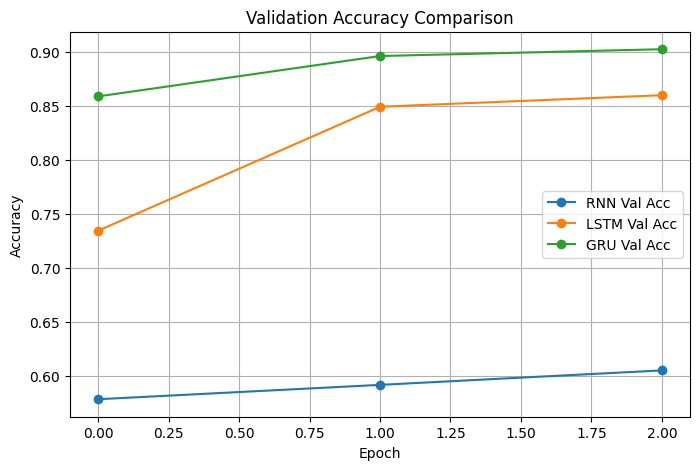

In [ ]:
# Plot validation accuracies
plt.figure(figsize=(8,5))

plt.plot(rnn_val_accs, marker="o", label="RNN Val Acc")
plt.plot(lstm_val_accs, marker="o", label="LSTM Val Acc")
plt.plot(gru_val_accs, marker="o", label="GRU Val Acc")

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


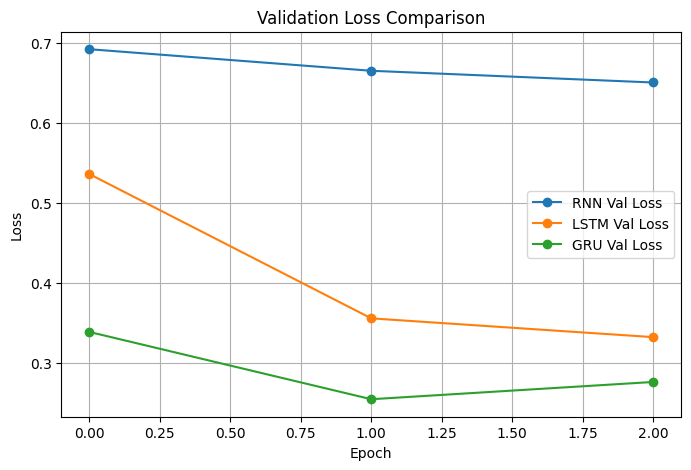

In [22]:
# Plot validation losses
plt.figure(figsize=(8,5))

plt.plot(rnn_val_losses, marker="o", label="RNN Val Loss")
plt.plot(lstm_val_losses, marker="o", label="LSTM Val Loss")
plt.plot(gru_val_losses, marker="o", label="GRU Val Loss")

plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


RNN vs LSTM vs GRU - PERFORMANCE SUMMARY

In [23]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["Simple RNN", "LSTM", "GRU"],
    "Best Validation Accuracy": [
        max(rnn_val_accs),
        max(lstm_val_accs),
        max(gru_val_accs)
    ],
    "Epochs Trained": [
        len(rnn_val_accs),
        len(lstm_val_accs),
        len(gru_val_accs)
    ]
})

comparison_df


,Model,Best Validation Accuracy,Epochs Trained
0,Simple RNN,0.6053,3
1,LSTM,0.8603,3
2,GRU,0.9029,3


SAVE THE BEST MODEL

In [20]:
# Save the best-performing GRU model
torch.save({
    "model_state_dict": gru_model.state_dict(),
    "vocab": vocab,
    "embed_dim": EMBED_DIM,
    "hidden_dim": HIDDEN_DIM
}, "best_gru_model.pt")

print("Best GRU model saved as best_gru_model.pt")



Best GRU model saved as best_gru_model.pt
